In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random
import csv
import pandas as pd

Initial parameters

In [7]:
#Аргон
# перейти в Ленард-Джонсоновские единицы
k_B = 1.38 * 10 ** -23
#E_si = 93.3 * k_B 
E_si = 2 * 1.6568 * 10 ** -21
sigma = 3.4 * 10 ** -10
mass =  6.63 * 10 ** -26
time_step_si = 1 * 10 ** -15
r_k_si = 2.5 * sigma # обрезается потенциал
n = 125
l_si = (2 * n) ** (1 / 3) * sigma

In [34]:
125 / (l_si / sigma) ** 3

0.5000000000000001

In [9]:
l = l_si
r_k = r_k_si
E = E_si
time_step = time_step_si

System Inizialization

In [10]:
initial_coords = np.zeros((n, 3))
m = int(round(n ** (1 / 3)))
delta = l / m
#каждая частица получает свою ячейку, и случайно размещается в кубе в 2 раза меньше внутри своей ячейки
for i in range(m):
    for j in range(m):
        for k in range(m):
            initial_coords[i * (m * m) + j * m + k] += np.array([(delta / 2 + delta * k) + delta / 4 * random.random(), 
                                                 (delta / 2 + delta * j) + delta / 4 * random.random(),
                                                 (delta / 2 + delta * i) + delta / 4 * random.random()])

In [11]:
coords = initial_coords.copy()

In [12]:
T = 400
v = np.sqrt(3/2 * k_B * T / mass)
phi = list()
teta = list()
for i in range(n):
    phi.append(random.random() * 2 * np.pi)
    teta.append(random.random() * 2 * np.pi)
velocities = np.array([[v * np.cos(phi[i]) * np.sin(teta[i]), 
                        v * np.cos(phi[i]) * np.cos(teta[i]), 
                        v * np.sin(phi[i])] for i in range(n)])

velocities -= np.mean(velocities, axis=0)

In [13]:
natural_coords = initial_coords.copy()
natural_velocities = velocities.copy()

Functions for changing particles coordinates

In [14]:
def Force(coord1, coord2, E=E, sigma=sigma, r_k=r_k, dim=3):
    """The interaction force between two particles with coords coord1 and coord2
        constants epsilon and sigma are ...
        force formula derived from Lenard-Johnson potential"""

    vec = coord2 - coord1
    for k in range(dim):
        if vec[k] > l / 2:
            vec[k] -= l
        elif vec[k] < - l / 2:
            vec[k] += l
    
    r = np.linalg.norm(vec)
    #if r > r_k:
        #return 0
    return -4 * (E / sigma) * (12 * (sigma / r) ** 13  - 6 * (sigma / r) ** 7) * (vec / r)

In [15]:
def calculate_acceleration(k, coords: np.ndarray, n=n):
    """calculates force for particle k 
    as a sum of interactions with other particles with the func Force"""
    coord = coords[k]
    acceleration = np.zeros(3)
    for i in range(n):
        if i != k:
            coord_ = coords[i]
            acceleration += Force(coord, coord_) / mass
    return acceleration

In [16]:
def check_border(coords: np.ndarray, border=np.array([l, l, l])):
    for coord in coords:
        for i, axis_coord in enumerate(coord):
            if axis_coord >= border[i]:
                coord[i] -= border[i]
            if axis_coord <= 0:
                coord[i] += border[i]


In [17]:
def verle_step(natural_coords, coords, coords_previous, time_step = time_step, n=n):
    """Changes the particles coordinates per time step with Stermer-Verle method"""
    accelerations = np.array([calculate_acceleration(i, coords=coords) for i in range(n)])
    coords1 = 2 * coords - coords_previous + accelerations * time_step ** 2
    velocities1 = (coords1 - coords_previous) / time_step
    coords_previous1 = coords
    natural_coords = coords1.copy()
    check_border(coords1, coords_previous1)
    return coords1, coords_previous1, velocities1, natural_coords

In [18]:
def velocity_Verle_step(coords, velocities, time_step=time_step, N=n):
    accelerations = np.array([calculate_acceleration(i, coords=coords) for i in range(N)])
    next_coords = np.array(coords + velocities * time_step + (accelerations / 2) * time_step ** 2)
    check_border(next_coords)
    next_accelerations = np.array([calculate_acceleration(i, coords=next_coords) for i in range(N)])
    next_velocities = np.array(velocities + time_step * (accelerations + next_accelerations) / 2)
    return next_coords, next_velocities

In [19]:
def velocity_Verle_step_natural(coords, velocities, time_step=time_step, N=n):
    accelerations = np.array([calculate_acceleration(i, coords=coords) for i in range(N)])
    next_coords = np.array(coords + velocities * time_step + (accelerations / 2) * time_step ** 2)
    next_accelerations = np.array([calculate_acceleration(i, coords=next_coords) for i in range(N)])
    next_velocities = np.array(velocities + time_step * (accelerations + next_accelerations) / 2)
    return next_coords, next_velocities

In [20]:
def potential_energy(coords, E=E, sigma=sigma, r_k=r_k, dim=3):
    P = 0
    for i in range(n):
        for j in range(n):
            if i != j:
                vec = coords[i] - coords[j]

                for k in range(dim):
                    if vec[k] > l / 2:
                        vec[k] -= l
                    elif vec[k] < - l / 2:
                        vec[k] += l
                    
                r = np.linalg.norm(vec)
                P += 4 * E * ( (sigma / r) ** 12  - (sigma / r) ** 6)
    return P / 2

In [21]:
def kinetic_energy(velocities, mass=mass):
    K = np.sum(np.linalg.norm(velocities, axis=1) ** 2) * mass / 2
    return K

In [22]:
def get_energy(coords, velocities, N=n):
    K = kinetic_energy(velocities=velocities)
    P = potential_energy(coords=coords)
    return K, P

Computation

In [18]:
Energy_per_time = list()
kinetic = list()
potential = list()
delta = list()

coords_file = "125 -15 (50000) coords.csv"
velocities_file = "125 -15 (50000) velocities.csv"
natural_coords_file = "125 -15 (50000) natural_coords.csv"

N_step = 50000
with open(velocities_file, 'w', newline='') as v_file:
    v_writer = csv.writer(v_file, delimiter=',', lineterminator="\n")
    v_writer.writerow(["Vx", "Vy", "Vz"])
    with open(coords_file, 'w', newline='', ) as file:
        writer = csv.writer(file, delimiter="\t", lineterminator="\nAr\t")
        last_row_writer = csv.writer(file, delimiter="\t", lineterminator="\n")
        for i in range(N_step):
            coords, velocities = velocity_Verle_step(coords=coords, velocities=velocities)

            #diffusion
            natural_coords, natural_velocities = velocity_Verle_step_natural(natural_coords, natural_velocities)
            delta.append((np.linalg.norm((natural_coords - initial_coords) / sigma, axis=1) ** 2).mean())

            K, P = get_energy(coords, velocities)
            kinetic.append(K)
            potential.append(P)
    
            for v in velocities:
                v_writer.writerow(v)
            
            last_row_writer.writerow([n])
            writer.writerow(["comment"])
            
            for row in coords[:-1]:
                writer.writerow(row / sigma * 10)
            last_row_writer.writerow(coords[-1]  / sigma * 10)

            if (i + 1) % (N_step / 10) == 0:
                print((i + 1) / N_step * 100, '%')
    file.close()
v_file.close()

10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %


Conservation of Energy

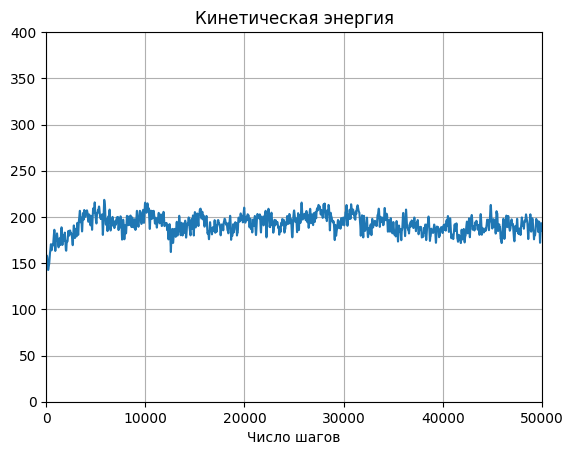

In [19]:
time = (np.arange(len(kinetic)) + 1)
fig, ax = plt.subplots()
ax.plot(time, np.array(kinetic) / E_si)
ax.grid()
ax.set_xlim((0, N_step))

#M = kinetic.max()

ax.set_ylim((0, 400))
plt.xlabel("Число шагов")
plt.title("Потенциальная энергия")
plt.title("Кинетическая энергия")
plt.show()

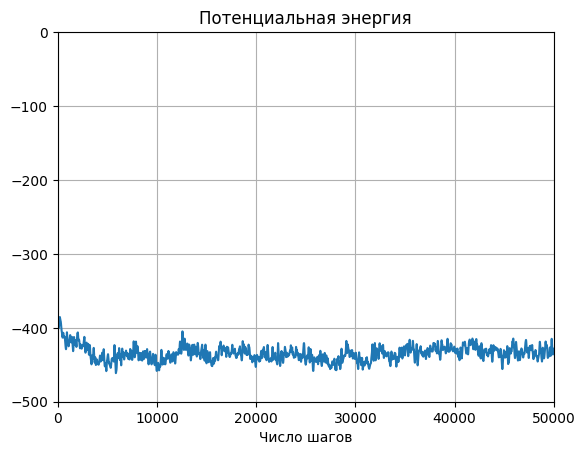

In [20]:
time = (np.arange(len(potential)) + 1)
fig, ax = plt.subplots()
ax.plot(time, np.array(potential) / E_si)
ax.grid()

#M = max(0, 2 * potential.max())
#m = min(0, 2 * potential.min())

ax.set_xlim((0, N_step))
ax.set_ylim((-500, 0))
plt.xlabel("Число шагов")
plt.title("Потенциальная энергия")
plt.show()

In [21]:
Energy = np.array(potential) / E_si + np.array(kinetic) / E_si
M = max(0, Energy.max())
m = min(0, Energy.max())

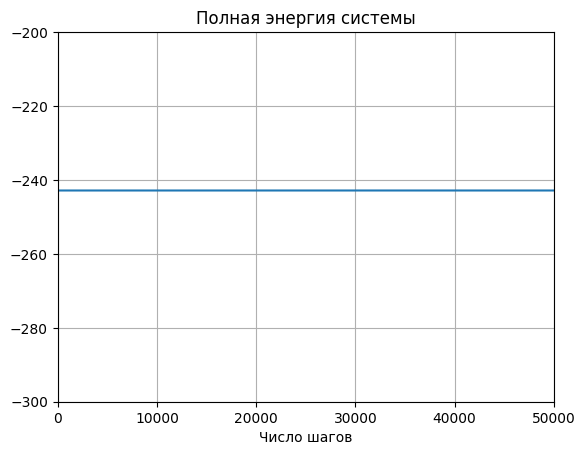

In [22]:
fig, ax = plt.subplots()
time = (np.arange(len(potential)) + 1)
ax.plot(time, Energy)
ax.set_xlim((0, N_step))
#ax.set_ylim(2 * m, 2 * M)
ax.set_ylim((-300, -200))
ax.grid()
plt.xlabel("Число шагов")
plt.title("Полная энергия системы")
plt.show()

Maxwell's velocities distribution

In [23]:
velocities_file = "125 -15 (50000) velocities.csv"
data = pd.read_csv(velocities_file)

In [24]:
V_x = np.array(data['Vx'])
V_y = np.array(data['Vy'])
V_z = np.array(data['Vz'])

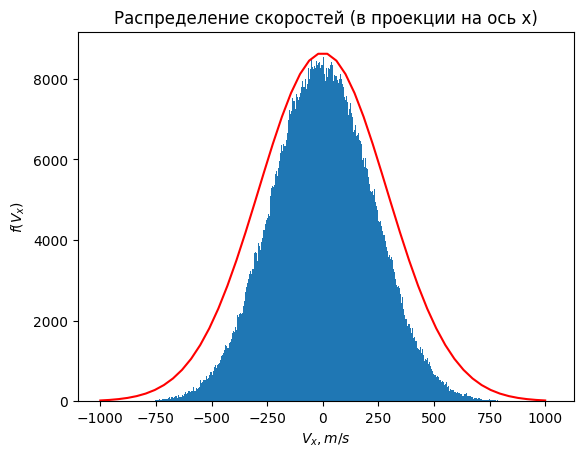

In [24]:
fig, ax = plt.subplots()
ax.hist(V_x, bins=2500)
x = np.linspace(-1000, 1000)
ax.plot(x, np.sqrt(mass / (2 * np.pi * k_B * T)) * np.exp(- x ** 2 * mass / (2 * k_B * T)) * V_x.shape[0], color='r')
#ax.set_ylim(0, 400)
plt.xlabel("$V_x, m/s$")
plt.ylabel("$f(V_x)$")
plt.title("Распределение скоростей (в проекции на ось x)")
plt.show()

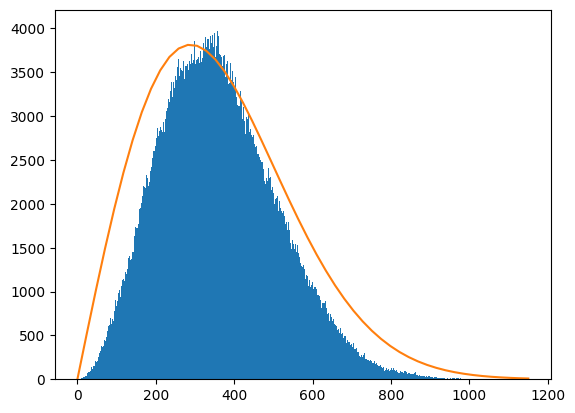

In [106]:
fig, ax = plt.subplots()
V = (V_x**2 + V_y**2 + V_z**2) ** (1/2)
x = np.linspace(0, 1150)
ax.hist(V, bins=5000)
ax.plot(x, 2 * np.pi * x * V.shape[0] / 100 * (np.sqrt(mass / (2 * np.pi * k_B * T)) ** 3) * np.exp(-(x ** 2) * mass / (2 * k_B * T)) * 21000)
plt.show()

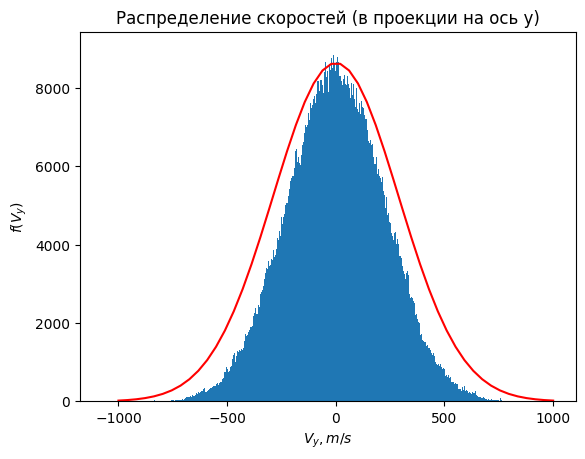

In [26]:
fig, ax = plt.subplots()
ax.hist(V_y, bins=2500)
y = np.linspace(-1000, 1000)
ax.plot(x, np.sqrt(mass / (2 * np.pi * k_B * T)) * np.exp(- y ** 2 * mass / (2 * k_B * T)) * V_y.shape[0], color='r')
#ax.set_ylim(0, 2000)
plt.xlabel("$V_y, m/s$")
plt.ylabel("$f(V_y)$")
plt.title("Распределение скоростей (в проекции на ось y)")
plt.show()

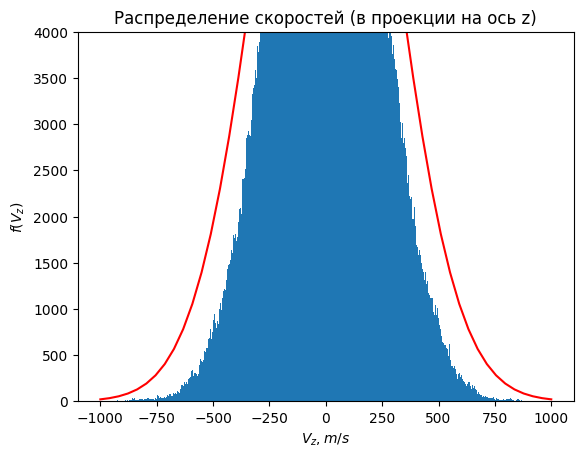

In [27]:
fig, ax = plt.subplots()
ax.hist(V_z, bins=2300)
z = np.linspace(-1000, 1000)
ax.plot(z, np.sqrt(mass / (2 * np.pi * k_B * T)) * np.exp(- z ** 2 * mass / (2 * k_B * T)) * V_z.shape[0], color='r')
ax.set_ylim(0, 4000)
plt.xlabel("$V_z, m/s$")
plt.ylabel("$f(V_z)$")
plt.title("Распределение скоростей (в проекции на ось z)")
plt.show()

0.827


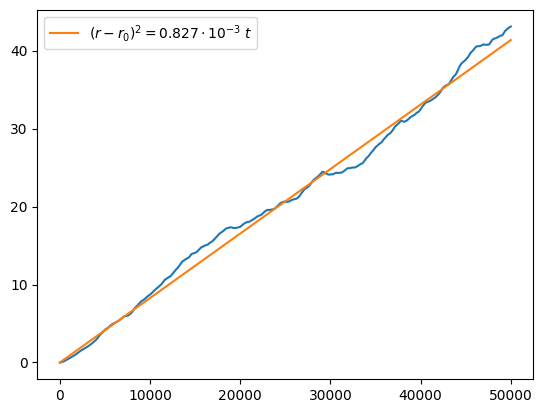

In [25]:
delta = pd.read_csv("125 -15 (50000) delta.csv")
k =  np.polyfit(np.arange(len(delta)), np.array(delta), deg=1)[0]
plt.plot(np.arange(len(delta)), np.array(delta))
x = np.linspace(0, 50000)
plt.plot(x, k * x, label = "$(r - r_0)^2 = 0.827 \cdot 10^{-3} \; t$")
plt.legend()
plt.show()

$$D = \frac{1}{6} \cdot \frac{\overline{x^2}}{t}$$
$$D = 1,0 \cdot 10^{-4} \; \frac{см^2}{c}$$
$$D = \frac{2 \lambda \langle \upsilon \rangle}{3}$$
$$\lambda = \frac{3D}{2 \sqrt{\frac{8 kT}{\pi \mu}}}$$
$$\lambda = 0,95 \cdot \sigma $$
$$\lambda = \frac{1}{n \cdot S} $$ 
$$S = \frac{1}{n \lambda} = 2,1 \sigma ^ 2$$

Дадим грубую оценку площади сечения столкновения атомов Аргона из закона сохранения энергии
$$\frac{m \overline{\upsilon^2}}{2} = 4 \varepsilon \cdot [ (\frac{\sigma}{r})^{12} - (\frac{\sigma}{r})^6 ]$$
Решая квадратное уравнение относительно $(\frac{\sigma}{r})^6$ , получаем диаметр сечения столкновения
$$d = 1,22 \sigma $$
$$S = \frac{\pi d^2}{4} = 1,2 \sigma^2$$
Отсюда получим значение длины свободного пробега:
$$ \lambda = \frac{1}{nS} = 1.3 \sigma$$

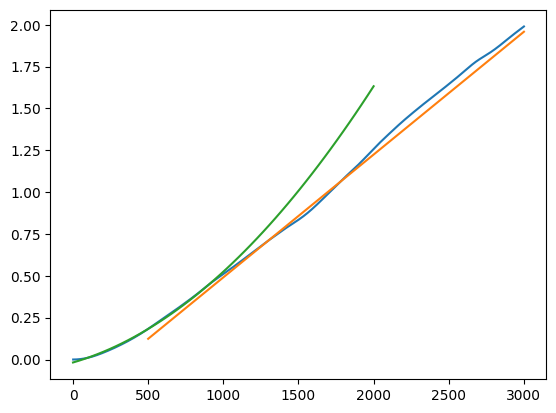

In [42]:
a, b, c = np.polyfit(np.arange(1, 1002), np.array(delta[:1001]), deg=2)
k, q = np.polyfit(np.arange(1001, 2001), np.array(delta[1001:2001]), deg=1)
plt.plot(np.arange(1, 3001), np.array(delta[:3000]))
x_1 = np.linspace(0, 2000)
x_2 = np.linspace(500, 3000)
plt.plot(x_2, k * x_2 + q)
plt.plot(x_1, a * x_1**2 + b * x_1 + c)
plt.show()

На начальном участке (первые 1000 шагов) видно, что зависимость среднего квадрата смещения атомов от времени квадратичная, т.е. модуль среднего смещения линейно зависит от времени. Следовательно, частицы в этом интервале времени движутся равномерно со своими начальными скоростями, а Ленард-Джонсоновским взаимодействием можно пренебречь. Из этих соображений дадим оценку длины свободного пробега:
$$ \lambda = \langle \upsilon \rangle  \cdot \tau = \langle \upsilon \rangle \cdot N \Delta t $$
$$ \lambda = 1,35 \sigma $$ 

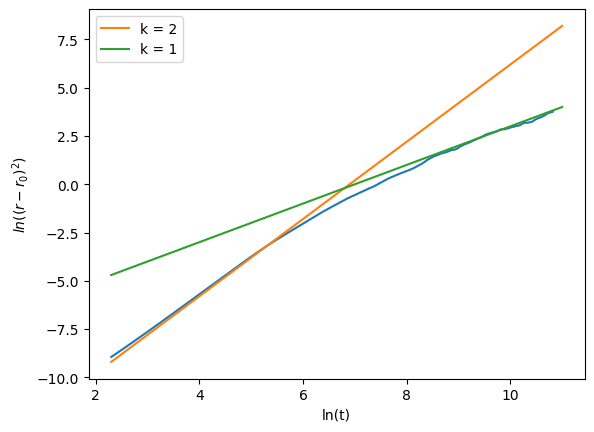

In [145]:
plt.plot(np.log(np.arange(10, 50000)), np.log(np.array(delta[10:50000])))
x = np.linspace(2.3, 11)
plt.plot(x, 2 * x - 13.8, label="k = 2")
plt.plot(x, x - 7, label="k = 1")
plt.legend()
plt.xlabel("ln(t)")
plt.ylabel("$ln((r - r_0)^2)$")
plt.show()

In [40]:
np.exp(7)

1096.6331584284585

In [38]:
delta_file = "125 -15 (50000) delta.csv"
with open(delta_file, 'w', newline="") as file:
    delta_writer = csv.writer(file, delimiter=' ', lineterminator="\n")
    delta_writer.writerow(["delta"])
    for elem in delta:
        delta_writer.writerow([elem])
file.close()